# Preparing

### needed libraries

In [229]:
import pandas as pd
import numpy as np
import csv
import os
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import wordnet
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [230]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
vectorizer = CountVectorizer()
tf_idf_vectorizer = TfidfVectorizer()

[nltk_data] Downloading package stopwords to /home/ayman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ayman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### converting review-polarity-negative

In [231]:
directory_path = "/home/ayman/Documents/NLP_PROJECT/review_polarity/txt_sentoken/neg"
text_data = []
for filename in os.listdir(directory_path):
    with open(os.path.join(directory_path, filename), 'r') as file:
        text = file.read()
        text_data.append(text)
csv_path = "/home/ayman/Documents/NLP_PROJECT/review_polarity/csv/review-polarity-neg.csv"
with open(csv_path, 'w', newline='') as file:
    writer = csv.writer(file)
    for text in text_data:
        writer.writerow([[text]])

### converting review-polarity-positive

In [232]:
directory_path = "/home/ayman/Documents/NLP_PROJECT/review_polarity/txt_sentoken/pos"
text_data = []
for filename in os.listdir(directory_path):
    with open(os.path.join(directory_path, filename), 'r') as file:
        text = file.read()
        text_data.append(text)
csv_path = "/home/ayman/Documents/NLP_PROJECT/review_polarity/csv/review-polarity-pos.csv"
with open(csv_path, 'w', newline='') as file:
    writer = csv.writer(file)
    for text in text_data:
        writer.writerow([[text]])

### Read from csv

In [233]:
pos = pd.DataFrame(columns = ["Reviews"])
neg = pd.DataFrame(columns = ["Reviews"])

pos["Reviews"] = pd.read_csv('./review_polarity/csv/review-polarity-pos.csv', header = None)
neg["Reviews"] = pd.read_csv('./review_polarity/csv/review-polarity-neg.csv', header = None)

# PreProcessing

### Reviews Preprocessing

In [234]:
def reviews_cleaning(data):
# Convert text to lowercase
    data['Reviews'] = data['Reviews'].apply(lambda x: str(x).lower())

    # Replace newline characters with an empty string
    data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\\n', ' ', x))

    # Remove special characters and punctuations
    data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'[^\w\s]+', '', x))

    # Remove numbers
    data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.split() if not any(char.isdigit() for char in word)]))
    
    # Remove extra whitespaces
    data['Reviews'] = data['Reviews'].apply(lambda x: re.sub(r'\s+', ' ', x))
    
    # Remove stop words
    data['Reviews'] = data['Reviews'].apply(lambda x: " ".join([word for word in x.lower().split() if word not in stop_words]))
    
    # Remove empty strings
    data['Reviews'] = data['Reviews'][data['Reviews'].apply(lambda x: len(x)>0)]
    
    return data

In [235]:
pos = reviews_cleaning(pos)
neg = reviews_cleaning(neg)

### Tokenization & lemmatization

In [236]:
# Tokenization
pos['Reviews'] = pos['Reviews'].apply(word_tokenize)
# Lemmatization
lemmatizer = WordNetLemmatizer()
pos['Reviews'] = pos['Reviews'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Tokenization
neg['Reviews'] = neg['Reviews'].apply(word_tokenize)
# Lemmatization
lemmatizer = WordNetLemmatizer()
neg['Reviews'] = neg['Reviews'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


In [237]:
pos

,Reviews
0,"[dont, let, following, quirk, review, fool, be..."
1,"[often, laugh, hard, movie, head, hurt, thats,..."
2,"[insider, look, scandalridden, run, democratic..."
3,"[usually, movie, something, soiled, rug, big, ..."
4,"[long, illustrious, career, robin, williams, i..."
...,...
995,"[saw, night, hunter, long, time, since, gasped..."
996,"[synopsis, cultural, exploration, chinese, ame..."
997,"[tim, burton, sleepy, hollow, mysterious, head..."
998,"[upon, taking, seat, theater, surveying, crowd..."


# Feature Extraction

### TF-IDF

In [81]:
# Convert the tokenized and lemmatized corpus into numerical vectors using BoW
pos_bag = tf_idf_vectorizer.fit_transform(pos['Reviews'].apply(lambda x: ' '.join(x)))

# Convert the tokenized and lemmatized corpus into numerical vectors using BoW
neg_bag = tf_idf_vectorizer.fit_transform(neg['Reviews'].apply(lambda x: ' '.join(x)))

### Bag Of Words

In [190]:
# Convert the tokenized and lemmatized corpus into numerical vectors using BoW
pos_bag = vectorizer.fit_transform(pos['Reviews'].apply(lambda x: ' '.join(x)))

# Convert the tokenized and lemmatized corpus into numerical vectors using BoW
neg_bag = vectorizer.fit_transform(neg['Reviews'].apply(lambda x: ' '.join(x)))


### PCA visualization

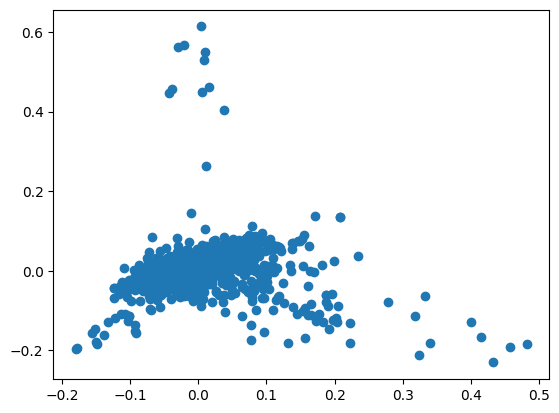

In [82]:
# Perform PCA
pca = PCA(n_components=2)
pca_bow = pca.fit_transform(pos_bag.toarray())
# Plot the results
plt.scatter(pca_bow[:,0], pca_bow[:,1])
plt.show()

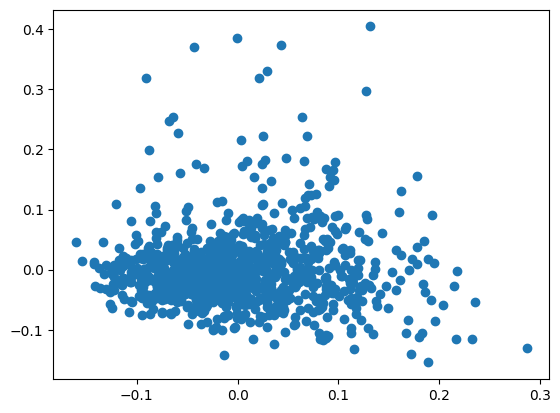

In [83]:
# Perform PCA
pca = PCA(n_components=2)
pca_bow = pca.fit_transform(neg_bag.toarray())
# Plot the results
plt.scatter(pca_bow[:,0], pca_bow[:,1])
plt.show()

### Word2Vec

In [238]:
# Train a Word2Vec model on the list of sentences
sentences = pd.concat([pos, neg])
model = Word2Vec(sentences, window=5, vector_size = 100, min_count=1, workers=4)

model

In [239]:
def get_feature_vector(tokens, model):
    feature_vector = np.zeros((100,), dtype="float32") # assuming size=100 in Word2Vec
    n_words = 0
    for word in tokens:
        if word in model.wv.key_to_index:
            feature_vector = np.add(feature_vector, model.wv[word])
            n_words += 1
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

In [240]:
# input features
X = np.zeros((len(sentences), 100), dtype="float32")
for i, review in enumerate(sentences):
    X[i] = get_feature_vector(review, model)

In [241]:
# target variable
Y = [0]*len(neg) + [1]*len(pos)

In [242]:
len(X)

2000

In [243]:
len(Y)

2000

### Naive Bayes

In [244]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the classifier
clf = GaussianNB()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Evaluate the classifier on the testing set
accuracy = clf.score(X_test, y_test)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: " + str(accuracy) + "\nRecall: " + str(recall) + "\nF1: " + str(f1) + "\nPrecision: " + str(precision))


Accuracy: 0.5025
Recall: 1.0
F1: 0.6688851913477537
Precision0.5025
